In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle

#Librería de geolocalizacion
from geopy.geocoders import Nominatim

import csv
import io
import json

#Librería de clima
import requests
from pprint import pprint

# Librerías para convertir en unix time
import datetime
from datetime import timezone
import dateutil.parser

In [ ]:
!pip install geopy
!pip install requests
!pip install xgboost==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/ML2022/TESIS/Version2/AEPICKUPDELIVERY3.csv',sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dataset.head()

,CLIENTE,GUIA,FECHA_GUIA,ESTADO_GUIA,FECHA_ENTREGA,SERVICIO,ORIGEN,DESTINO,ORIGEN_BASE,DESTINO_BASE,...,FECHA MANIFIESTO_INFORMADO,FECHA MANIFIESTO_RECOGIDO,FECHA MANIFIESTO_VERIFICADO,RESP_REPARTO,FECHA REPARTO,NUMERO REPARTO,TIPO_INCIDENCIA_REPARTO,FECHA_INCIDENCIA_REPARTO,FECHA_COMPROMISO,SUGERENCIAS
0,SWISSJUST LATINOAMERICA S.A. SUCURSAL PERU,SW093885,07/04/2022,Entregada,21/04/2022,PROVINCIA,LIMA,JAEN,LIMA,JAEN,...,08/04/2022,11/04/2022,11/04/2022,DBERRU,18/04/2022,169693.0,DIRECCION INCOMPLETA,21/04/2022,20/04/2022,REGISTRAR CORRECTAMENTE LA DIRECCION DE DESTINO
1,DINET S.A.,BT144308,05/04/2022,Entregada,07/04/2022,BIG- TICKET PROVINCIA,LIMA,TRUJILLO,LIMA,TRUJILLO,...,05/04/2022,06/04/2022,06/04/2022,LENRIQUE,07/04/2022,167278.0,REPROGRAMACION,06/04/2022,07/04/2022,#N/D
2,HINODE PERU S.A.C.,H0216383,06/04/2022,Entregada,07/04/2022,PEDIDO,LIMA,HUANCAYO,LIMA,HUANCAYO,...,06/04/2022,07/04/2022,07/04/2022,MEMENDOZA,07/04/2022,167312.0,AUSENTE,07/04/2022,07/04/2022,COORDINAR PREEVIAMENTE CON EL DESTINATARIO LA ...
3,HINODE PERU S.A.C.,H0216680,09/04/2022,Entregada,12/04/2022,MAYORISTA,LIMA,PUCALLPA,LIMA,PUCALLPA,...,09/04/2022,11/04/2022,11/04/2022,CPINEDO,11/04/2022,168387.0,COORDINADO,11/04/2022,12/04/2022,#N/D
4,NATURA COSMETICOS S.A.,36961085,02/04/2022,Entregada,09/04/2022,PEDIDO,LURIN,CAS SANCRISTOBAL,LIMA,TINGO MARIA,...,02/04/2022,06/04/2022,06/04/2022,GTRUJILLO,08/04/2022,167523.0,REEMBARQUE COLECTIVO,07/04/2022,09/04/2022,ENTREGAR NUMERO DE REFERENCIA DE LOS INTERMEDI...


# Procesamiento de los datos del clima

In [ ]:
dataset = dataset.drop(dataset[dataset["FECHA REPARTO"].isna() == True].index)

In [ ]:
# Se crea un nuevo dataset
subDataset = dataset.groupby(by=["DEPARTAMENTO","FECHA REPARTO"]).size().reset_index().rename(columns={0:"count"})

In [ ]:
# Se crean agregan los parámetros de la longitud y longitud de los departamentos
subDataset["Latitud"]=0
subDataset["Longitud"]=0

## Geolocalizamos los departamentos**

In [ ]:
for i in range(len(subDataset)):
  loc = Nominatim(user_agent="GetLoc") 
  departamento = subDataset.loc[i,"DEPARTAMENTO"]
  getLoc = loc.geocode(departamento) 
  longitud =  getLoc.longitude
  latitud = getLoc.latitude
  subDataset.loc[i,"Latitud"] = latitud
  subDataset.loc[i,"Longitud"] = longitud

## **Llamamos al api del clima**

In [ ]:
#url = "http://history.openweathermap.org/data/2.5/history/city?lat={}&lon={}&type=hour&start={}&end={}&appid=&units=metric".format()
subDataset["TEMPERATURA"]=0
subDataset["HUMEDAD"]=0
subDataset["CLIMA"]= ""

In [ ]:
for i in range(len(subDataset)):
  fechaReparto = subDataset.loc[i,"FECHA REPARTO"]
  my_ts = fechaReparto.split("/")
  dt = datetime.datetime(int(my_ts[2]), int(my_ts[1]), int(my_ts[0]))
  timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
  dateInit = str(timestamp+64800)
  dateInitUnix = dateInit[0:len(dateInit)-2]
  url = "http://history.openweathermap.org/data/2.5/history/city?lat={}&lon={}&type=hour&start={}&end={}&appid=b9c3fde5b6c1179bccc0b366a4d04fd0&units=metric".format(str(subDataset.loc[i,"Latitud"]),str(subDataset.loc[i,"Longitud"]),dateInitUnix,dateInitUnix)
  res = requests.get(url)
  data = res.json()
  temperatura = data["list"][0]["main"]["temp"]
  humedad = data["list"][0]["main"]["humidity"]
  clima = data["list"][0]["weather"][0]["main"]
  subDataset.loc[i,"TEMPERATURA"] = temperatura
  subDataset.loc[i,"HUMEDAD"] = humedad
  subDataset.loc[i,"CLIMA"] = clima

In [ ]:
subDataset.drop(subDataset.loc[subDataset["DEPARTAMENTO"]=="ANDAHUAYLAS"].index, inplace=True)

In [ ]:
len(subDataset["DEPARTAMENTO"].unique())

25

In [ ]:
subDataset

,DEPARTAMENTO,FECHA REPARTO,count,Latitud,Longitud,TEMPERATURA,HUMEDAD,CLIMA
0,AMAZONAS,04/04/2022,2,-4.479925,-63.51854,27.35,71,Rain
1,AMAZONAS,05/04/2022,107,-4.479925,-63.51854,29.42,69,Clouds
2,AMAZONAS,06/04/2022,4,-4.479925,-63.51854,30.36,62,Clouds
3,AMAZONAS,07/04/2022,31,-4.479925,-63.51854,32.22,52,Clouds
4,AMAZONAS,08/04/2022,58,-4.479925,-63.51854,32.15,53,Rain
...,...,...,...,...,...,...,...,...
326,UCAYALI,10/04/2022,222,-9.000000,-73.50000,30.66,54,Clouds
327,UCAYALI,11/04/2022,242,-9.000000,-73.50000,31.29,57,Clouds
328,UCAYALI,12/04/2022,135,-9.000000,-73.50000,30.79,58,Clouds
329,UCAYALI,13/04/2022,3,-9.000000,-73.50000,28.25,83,Clouds


# Índices de delitos

In [ ]:
response = requests.get('http://datacrim.inei.gob.pe/csv_controller/index?desde=tematico&id=40001')

In [ ]:
df = pd.read_csv(io.StringIO(response.text), sep=',', header=None, quoting=csv.QUOTE_ALL)
df[0] = df[0].astype('string')
df[1] = df[1].astype('string')
df[2] = df[2].astype('string')

In [ ]:
dataCrime = df.loc[(df[0]=="2021") & (df[1]!="NACIONAL")]

In [ ]:
val = list(dataCrime.loc[dataCrime[1]=="DEPARTAMENTO DE LIMA 2/"][2])[0]

In [ ]:
dataCrime.drop(dataCrime.loc[dataCrime[1]=="DEPARTAMENTO DE LIMA 2/"].index, inplace=True)
dataCrime[2] = dataCrime[2].astype('float')
indiceLima = int(dataCrime.loc[dataCrime[1]=="LIMA METROPOLITANA 1/"].index[0])
indiceCallao = int(dataCrime.loc[dataCrime[1]=="PROVINCIA CONSTITUCIONAL DEL CALLAO"].index[0])
dataCrime.loc[indiceCallao,1] = "CALLAO"
dataCrime.loc[indiceLima,1] = "LIMA"

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

## Indices de problemas naturales

In [ ]:
url = 'https://systems.inei.gob.pe/SIRTOD/app/consulta/getTableDataYear?indicador_listado=262432%2C262433%2C262429%2C420794%2C262428%2C420795&tipo_ubigeo=1&desde_anio=2020&hasta_anio=2020&ubigeo_listado=&idioma=ES'
dataProblemaGeografico = list()
dataProblemaGeograficoRequest = requests.get(url)

In [ ]:
dataProblemaGeografico = dataProblemaGeograficoRequest.json()

## Poblacion econmicamente activa

In [ ]:
url2 = "https://systems.inei.gob.pe/SIRTOD/app/consulta/getTableDataYear?indicador_listado=389219&tipo_ubigeo=1&desde_anio=2020&hasta_anio=2020&ubigeo_listado=&idioma=ES"
dataPEA = list()
dataPEA = requests.get(url2)

In [ ]:
dataProblemaPEA = dataPEA.json()

## Indices de accidentes de tránsito

In [ ]:
#https://systems.inei.gob.pe/SIRTOD/app/consulta/getTableDataYear?indicador_listado=394842&tipo_ubigeo=1&desde_anio=2021&hasta_anio=2021&ubigeo_listado=&idioma=ES
url3 = "https://systems.inei.gob.pe/SIRTOD/app/consulta/getTableDataYear?indicador_listado=394842&tipo_ubigeo=1&desde_anio=2021&hasta_anio=2021&ubigeo_listado=&idioma=ES"
dataAccidentesTransito = list()
dataAccidentesTransitoRequest = requests.get(url3)

In [ ]:
dataAccidentesTransito = dataAccidentesTransitoRequest.json()

## Preprocesamiento de los datos obtenidos

In [ ]:
listaDepartamentos = list()
for i in dataProblemaGeografico:
  if (i["departamento"] not in listaDepartamentos):
    listaDepartamentos.append(i["departamento"])

In [ ]:
# Calculo de datos de problemas naturales
listaProblemasGeograficoDatos = [0]*25
for i in dataProblemaGeografico:
  if (i["departamento"] in listaDepartamentos):
    index = listaDepartamentos.index(i["departamento"])
    listaProblemasGeograficoDatos[index] = int(listaProblemasGeograficoDatos[index]) + int(i["dato"].replace(" ",""))

In [ ]:
# Calculo de datos de adultos mayores
listaDatosPEA = [0]*25
for i in dataProblemaPEA:
  if (i["departamento"] in listaDepartamentos):
    index = listaDepartamentos.index(i["departamento"])
    variable = i["dato"].replace(" ","")
    variableaux = variable.replace(",",".")
    listaDatosPEA[index] = float(listaDatosPEA[index]) + float(variableaux.replace(" ",""))

In [ ]:
# Calculo de datos de accidentes de transito
listaDatosAccTransito = [0]*25
for i in dataAccidentesTransito:
  if (i["departamento"] in listaDepartamentos):
    index = listaDepartamentos.index(i["departamento"])
    listaDatosAccTransito[index] = int(listaDatosAccTransito[index]) + int(i["dato"].replace(" ",""))

In [ ]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
listaDepartamentos = list(map(lambda x : normalize(x), listaDepartamentos))

In [ ]:
dataCrime.rename(columns = {0:'AÑO', 1:'DEPARTAMENTO',2:'INDICE_DELITOS'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataCrime["CANT_FENO_NAT"]=0
dataCrime["CANT_PEA"]=0
dataCrime["CANT_ACC_TRANSITO"]=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
for i in dataCrime.index:
  departamento = str(dataCrime.loc[i,"DEPARTAMENTO"])
  if (departamento in listaDepartamentos):
    index_departamento = listaDepartamentos.index(departamento)
    val_prob_geo = listaProblemasGeograficoDatos[index_departamento]
    val_cant_pea = listaDatosPEA[index_departamento]
    val_cant_acc_transito = listaDatosAccTransito[index_departamento]
    dataCrime.loc[i,"CANT_FENO_NAT"] = val_prob_geo
    dataCrime.loc[i,"CANT_PEA"] = val_cant_pea
    dataCrime.loc[i,"CANT_ACC_TRANSITO"] = val_cant_acc_transito

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Uniendo submatrices de datos

In [ ]:
newDataSet = pd.merge(subDataset, dataCrime, how='inner', on = 'DEPARTAMENTO')

In [ ]:
newDataSet["DEPARTAMENTO"].unique()

array(['AMAZONAS', 'ANCASH', 'APURIMAC', 'AREQUIPA', 'AYACUCHO',
       'CAJAMARCA', 'CALLAO', 'CUSCO', 'HUANCAVELICA', 'HUANUCO', 'ICA',
       'JUNIN', 'LA LIBERTAD', 'LAMBAYEQUE', 'LIMA', 'LORETO',
       'MADRE DE DIOS', 'MOQUEGUA', 'PASCO', 'PIURA', 'PUNO',
       'SAN MARTIN', 'TACNA', 'TUMBES', 'UCAYALI'], dtype=object)

In [ ]:
newDataSet

,DEPARTAMENTO,FECHA REPARTO,count,Latitud,Longitud,TEMPERATURA,HUMEDAD,CLIMA,AÑO,INDICE_DELITOS,CANT_FENO_NAT,CANT_PEA,CANT_ACC_TRANSITO
0,AMAZONAS,04/04/2022,2,-4.479925,-63.51854,27.35,71,Rain,2021,101.840789,368,243.1,473
1,AMAZONAS,05/04/2022,107,-4.479925,-63.51854,29.42,69,Clouds,2021,101.840789,368,243.1,473
2,AMAZONAS,06/04/2022,4,-4.479925,-63.51854,30.36,62,Clouds,2021,101.840789,368,243.1,473
3,AMAZONAS,07/04/2022,31,-4.479925,-63.51854,32.22,52,Clouds,2021,101.840789,368,243.1,473
4,AMAZONAS,08/04/2022,58,-4.479925,-63.51854,32.15,53,Rain,2021,101.840789,368,243.1,473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,UCAYALI,10/04/2022,222,-9.000000,-73.50000,30.66,54,Clouds,2021,111.005976,349,276.2,504
326,UCAYALI,11/04/2022,242,-9.000000,-73.50000,31.29,57,Clouds,2021,111.005976,349,276.2,504
327,UCAYALI,12/04/2022,135,-9.000000,-73.50000,30.79,58,Clouds,2021,111.005976,349,276.2,504
328,UCAYALI,13/04/2022,3,-9.000000,-73.50000,28.25,83,Clouds,2021,111.005976,349,276.2,504


# Se verifica el tipo de dirección

In [ ]:
dataset["DIRECCION1"] = dataset["DIRECCION1"].str.upper()

In [ ]:
dataset["TIENE_AV"] = dataset.DIRECCION1.str.contains("AV|AVENIDA",regex=True,case=False)

In [ ]:
dataset["TIENE_JR"] = dataset.DIRECCION1.str.contains("JR|JIRON",regex=True,case=False)

In [ ]:
dataset["TIENE_CALLE"] = dataset.DIRECCION1.str.contains("CALLE",regex=True,case=False)

# Valores de respuestas

In [ ]:
dataset["TIPO_INCIDENCIA_REPARTO"].value_counts()

AUSENTE                          1480
ES OTRA ZONA                     1020
REEMBARQUE COLECTIVO              852
SOCIAL                            827
CLIMATICO                         484
COORDINADO                        468
DIRECCION INCOMPLETA              258
REPROGRAMACION                    239
REEMBARQUE ENTREGA EN AGENCIA     186
DESCONOCIDO/NO DA RAZÓN           129
DE VIAJE                           65
DIRECCION ERRADA                   64
FALLAS MECANICAS EN REPARTO        53
RECOJO EN OFICINA                  27
RECHAZADO                          27
DESPACHO ERRADO                    22
SE MUDO                            15
DIRECCIÓN NO ACCESIBLE              9
ZONA PELIGROSA                      8
MERCADERIA SINIESTRADA (ROBO)       2
NUEVA ZONA                          2
DIRECCION INEXACTA                  1
ZONA NO ACCESIBLE EN REPARTO        1
Name: TIPO_INCIDENCIA_REPARTO, dtype: int64

**Se elimina incidentes que no se pueden analizar por factores externos**



In [ ]:
dataset.shape

(37896, 45)

In [ ]:
newDataSet.to_csv('/content/drive/MyDrive/ML2022/TESIS/Version2/dataframe_apis.csv', # Indicar el nombre del archivo
                            index = True,              # Indicar si incluir o no la columna indice. En este caso, como es el DNI, ponemos que sí
                            sep = ';'                  # Indicamos el caracter a usarse como separador
                          )

In [ ]:
dataset.to_csv('/content/drive/MyDrive/ML2022/TESIS/Version2/dataframe_process.csv', # Indicar el nombre del archivo
                            index = True,              # Indicar si incluir o no la columna indice. En este caso, como es el DNI, ponemos que sí
                            sep = ';'                  # Indicamos el caracter a usarse como separador
                          )

In [ ]:
# Tipos de incidencia que no se tomarán en cuenta
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "COORDINADO"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "REPROGRAMACION"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "REEMBARQUE ENTREGA EN AGENCIA"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "DESCONOCIDO/NO DA RAZÓN"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "RECOJO EN OFICINA"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "RECHAZADO"].index)
dataset = dataset.drop(dataset[dataset.TIPO_INCIDENCIA_REPARTO == "DESPACHO ERRADO"].index)

**Se les asigna una etiqueta a los campos vacios de los atributos "TIPO_INCIDENCIA_REPARTO" y "SUGERENCIAS"**

In [ ]:
dataset['SUGERENCIAS'] = np.where(dataset["TIPO_INCIDENCIA_REPARTO"].isna(), 'OK', dataset['SUGERENCIAS'])

In [ ]:
dataset["TIPO_INCIDENCIA_REPARTO"] = np.where(dataset["TIPO_INCIDENCIA_REPARTO"].isna(), 'OK', dataset["TIPO_INCIDENCIA_REPARTO"])

In [ ]:
dataset.loc[dataset["SUGERENCIAS"]=="#N/D"]

,CLIENTE,GUIA,FECHA_GUIA,ESTADO_GUIA,FECHA_ENTREGA,SERVICIO,ORIGEN,DESTINO,ORIGEN_BASE,DESTINO_BASE,...,RESP_REPARTO,FECHA REPARTO,NUMERO REPARTO,TIPO_INCIDENCIA_REPARTO,FECHA_INCIDENCIA_REPARTO,FECHA_COMPROMISO,SUGERENCIAS,TIENE_AV,TIENE_JR,TIENE_CALLE


In [ ]:
dataset.loc[dataset["TIPO_INCIDENCIA_REPARTO"].isna()]

,CLIENTE,GUIA,FECHA_GUIA,ESTADO_GUIA,FECHA_ENTREGA,SERVICIO,ORIGEN,DESTINO,ORIGEN_BASE,DESTINO_BASE,...,RESP_REPARTO,FECHA REPARTO,NUMERO REPARTO,TIPO_INCIDENCIA_REPARTO,FECHA_INCIDENCIA_REPARTO,FECHA_COMPROMISO,SUGERENCIAS,TIENE_AV,TIENE_JR,TIENE_CALLE


In [ ]:
#array(['VERIFICADO', 'RECOGIDO', 'INFORMADO', 'PENDIENTE'], dtype=object)
dataset = dataset.drop(dataset[dataset.ESTADO_MANIFIESTO == "RECOGIDO"].index)
dataset = dataset.drop(dataset[dataset.ESTADO_MANIFIESTO == "PENDIENTE"].index)
dataset = dataset.drop(dataset[dataset.ESTADO_MANIFIESTO == "INFORMADO"].index)
dataset = dataset.drop(dataset[dataset.ESTADO_MANIFIESTO == "DDV"].index)

In [ ]:
# Eliminamos departaentos vacios
dataset = dataset.drop(dataset[dataset.DEPARTAMENTO.isnull()].index)

# Combinar Dataset con los parámetros de entrada

In [ ]:
#datasetFinal = pd.merge(dataset, subDataset, how="left")
datasetFinal = dataset.merge(newDataSet, how = 'left', left_on = ['DEPARTAMENTO', 'FECHA REPARTO'],  right_on = ['DEPARTAMENTO', 'FECHA REPARTO'])

In [ ]:
datasetFinal.to_csv('/content/drive/MyDrive/ML2022/TESIS/Version2/dataframe_process_antes_eliminar_columns.csv', # Indicar el nombre del archivo
                            index = True,              # Indicar si incluir o no la columna indice. En este caso, como es el DNI, ponemos que sí
                            sep = ';'                  # Indicamos el caracter a usarse como separador
                          )

In [ ]:
dataset = datasetFinal

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/ML2022/TESIS/Version2/dataframe_process_antes_eliminar_columns.csv',sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dataset.columns

Index(['Unnamed: 0', 'CLIENTE', 'GUIA', 'FECHA_GUIA', 'ESTADO_GUIA',
       'FECHA_ENTREGA', 'SERVICIO', 'ORIGEN', 'DESTINO', 'ORIGEN_BASE',
       'DESTINO_BASE', 'REMITENTE', 'CONSIGNATARIO', 'PAQUETES',
       'GESTORA_SERVICIO', 'REPRESENTANTE', 'CONTADOR_VISITAS',
       'FORMA_CONF_ENTREGA', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO',
       'DIRECCION1', 'DIRECCION2', 'FECHA_EMBARQUE', 'FECHA_SALIDA_PROYECT',
       'FECHA_LLEGADA_PROYECT', 'FECHA_LLEGADA_REAL',
       'PROVEEDOR DE TRANSPORTE', 'VIA', 'N_MANIFIESTO', 'FECHA_MANIFIESTO',
       'ESTADO_MANIFIESTO', 'INCIDENCIA_MANIFIESTO',
       'FECHA MANIFIESTO_INFORMADO', 'FECHA MANIFIESTO_RECOGIDO',
       'FECHA MANIFIESTO_VERIFICADO', 'RESP_REPARTO', 'FECHA REPARTO',
       'NUMERO REPARTO', 'TIPO_INCIDENCIA_REPARTO', 'FECHA_INCIDENCIA_REPARTO',
       'FECHA_COMPROMISO', 'SUGERENCIAS', 'TIENE_AV', 'TIENE_JR',
       'TIENE_CALLE', 'count', 'Latitud', 'Longitud', 'TEMPERATURA', 'HUMEDAD',
       'CLIMA', 'AÑO', 'INDICE_DELIT

**Ahora eliminaremos las columnas que no guardan relación**

In [ ]:
# Ahora eliminaremos las columnas que no guardan relación
dataset = dataset.drop(['GUIA'], axis=1)
dataset = dataset.drop(['AÑO'], axis=1)
dataset = dataset.drop(['DIRECCION1'], axis=1)
dataset = dataset.drop(['N_MANIFIESTO'], axis=1)
dataset = dataset.drop(['PROVINCIA'], axis=1)
dataset = dataset.drop(['DISTRITO'], axis=1)
dataset = dataset.drop(['NUMERO REPARTO'], axis=1)
dataset = dataset.drop(['FECHA MANIFIESTO_VERIFICADO'], axis=1)
dataset = dataset.drop(['ORIGEN_BASE'], axis=1)
dataset = dataset.drop(['REMITENTE'], axis=1)
dataset = dataset.drop(['FECHA_EMBARQUE'], axis=1)
dataset = dataset.drop(['FORMA_CONF_ENTREGA'], axis=1)
dataset = dataset.drop(['CONSIGNATARIO'], axis=1)
dataset = dataset.drop(['DESTINO_BASE'], axis=1)
dataset = dataset.drop(['REPRESENTANTE'], axis=1)
dataset = dataset.drop(['DIRECCION2'], axis=1)
dataset = dataset.drop(['FECHA_LLEGADA_PROYECT'], axis=1)
dataset = dataset.drop(['FECHA_LLEGADA_REAL'], axis=1)
dataset = dataset.drop(['FECHA MANIFIESTO_RECOGIDO'], axis=1)
dataset = dataset.drop(['FECHA MANIFIESTO_INFORMADO'], axis=1)
dataset = dataset.drop(['FECHA REPARTO'], axis=1)
dataset = dataset.drop(['DESTINO'], axis=1)
dataset = dataset.drop(['FECHA_COMPROMISO'], axis=1)
dataset = dataset.drop(['FECHA_MANIFIESTO'], axis=1)
dataset = dataset.drop(['RESP_REPARTO'], axis=1)
dataset = dataset.drop(['FECHA_INCIDENCIA_REPARTO'], axis=1)
dataset = dataset.drop(['FECHA_SALIDA_PROYECT'], axis=1)
dataset = dataset.drop(['FECHA_GUIA'], axis=1)
dataset = dataset.drop(['FECHA_ENTREGA'], axis=1)
dataset = dataset.drop(['ORIGEN'], axis=1)
dataset = dataset.drop(['GESTORA_SERVICIO'], axis=1)
dataset = dataset.drop(['PROVEEDOR DE TRANSPORTE'], axis=1)
dataset = dataset.drop(['CLIENTE'], axis=1)
dataset = dataset.drop(['count'], axis=1)
dataset = dataset.drop(['ESTADO_MANIFIESTO'], axis=1)
dataset = dataset.drop(['ESTADO_GUIA'], axis=1)
dataset = dataset.drop(['TIPO_INCIDENCIA_REPARTO'], axis=1)
dataset = dataset.drop(['Latitud'], axis=1)
dataset = dataset.drop(['Longitud'], axis=1)

In [ ]:
dataset.columns

Index(['Unnamed: 0', 'SERVICIO', 'PAQUETES', 'CONTADOR_VISITAS',
       'DEPARTAMENTO', 'VIA', 'INCIDENCIA_MANIFIESTO', 'SUGERENCIAS',
       'TIENE_AV', 'TIENE_JR', 'TIENE_CALLE', 'TEMPERATURA', 'HUMEDAD',
       'CLIMA', 'INDICE_DELITOS', 'CANT_FENO_NAT', 'CANT_PEA',
       'CANT_ACC_TRANSITO'],
      dtype='object')

In [ ]:
#Completamos los campos vaciós de las vias terrestres
moda = dataset['VIA'].mode()[0]
dataset['VIA'] = dataset['VIA'].fillna(moda)

In [ ]:
moda = dataset['SERVICIO'].mode()[0]
dataset['SERVICIO'] = dataset['SERVICIO'].fillna(moda)

In [ ]:
moda = dataset['DEPARTAMENTO'].mode()[0]
dataset['DEPARTAMENTO'] = dataset['DEPARTAMENTO'].fillna(moda)

In [ ]:
dataset['TIENE_AV'] = np.where(dataset['TIENE_AV']==True, 1, dataset['TIENE_AV'])
dataset['TIENE_AV'] = np.where(dataset['TIENE_AV']==False, 0, dataset['TIENE_AV'])
dataset['TIENE_AV'] = np.where(dataset['TIENE_AV'].isna()==True, 0, dataset['TIENE_AV'])
dataset['TIENE_JR'] = np.where(dataset['TIENE_JR']==True, 1, dataset['TIENE_JR'])
dataset['TIENE_JR'] = np.where(dataset['TIENE_JR']==False, 0, dataset['TIENE_JR'])
dataset['TIENE_JR'] = np.where(dataset['TIENE_JR'].isna()==True, 0, dataset['TIENE_JR'])
dataset['TIENE_CALLE'] = np.where(dataset['TIENE_CALLE']==True, 1, dataset['TIENE_CALLE'])
dataset['TIENE_CALLE'] = np.where(dataset['TIENE_CALLE']==False, 0, dataset['TIENE_CALLE'])
dataset['TIENE_CALLE'] = np.where(dataset['TIENE_CALLE'].isna()==True, 0, dataset['TIENE_CALLE'])
dataset['INCIDENCIA_MANIFIESTO'] = np.where(dataset['INCIDENCIA_MANIFIESTO'].isnull()==True, 'OK', dataset['INCIDENCIA_MANIFIESTO'])

In [ ]:
dataset['NO_TIENE_REF'] = 0
dataset['NO_TIENE_REF'] = np.where((dataset['TIENE_AV']==0) & (dataset['TIENE_JR']==0) & (dataset['TIENE_CALLE']==0), 1, dataset['NO_TIENE_REF'])

In [ ]:
dataset = dataset.drop(dataset[dataset.DEPARTAMENTO == "ANDAHUAYLAS"].index)

In [ ]:
dataset.count()

Unnamed: 0               36017
SERVICIO                 36017
PAQUETES                 36017
CONTADOR_VISITAS         36017
DEPARTAMENTO             36017
VIA                      36017
INCIDENCIA_MANIFIESTO    36017
SUGERENCIAS              36017
TIENE_AV                 36017
TIENE_JR                 36017
TIENE_CALLE              36017
TEMPERATURA              36017
HUMEDAD                  36017
CLIMA                    36017
INDICE_DELITOS           36017
CANT_FENO_NAT            36017
CANT_PEA                 36017
CANT_ACC_TRANSITO        36017
NO_TIENE_REF             36017
dtype: int64

In [ ]:
dataset.dtypes

Unnamed: 0                 int64
SERVICIO                  object
PAQUETES                   int64
CONTADOR_VISITAS           int64
DEPARTAMENTO              object
VIA                       object
INCIDENCIA_MANIFIESTO     object
SUGERENCIAS               object
TIENE_AV                  object
TIENE_JR                  object
TIENE_CALLE               object
TEMPERATURA              float64
HUMEDAD                  float64
CLIMA                     object
INDICE_DELITOS           float64
CANT_FENO_NAT            float64
CANT_PEA                 float64
CANT_ACC_TRANSITO        float64
NO_TIENE_REF               int64
dtype: object

# Convertir datos categóricos a numéricos

In [ ]:
dataset["TIENE_AV"] = dataset["TIENE_AV"].astype('int')
dataset["TIENE_JR"] =dataset["TIENE_JR"].astype('int')
dataset["TIENE_CALLE"] =dataset["TIENE_CALLE"].astype('int')
dataset["NO_TIENE_REF"] = dataset["NO_TIENE_REF"].astype('int')

In [ ]:
prueba_dataset = dataset.copy()

#Dictionario Servicios
listaServicios = dataset["SERVICIO"].unique().tolist()
dictionaryServicios = {servicio:listaServicios.index(servicio) for servicio in listaServicios}

#Dictionario Departamentos
listaDepartamentos = dataset["DEPARTAMENTO"].unique().tolist()
dictionaryDepartamentos = {departamento:listaDepartamentos.index(departamento) for departamento in listaDepartamentos}

#Dictionario Climas
listaClimas = dataset["CLIMA"].unique().tolist()
dictionaryClimas = {clima:listaClimas.index(clima) for clima in listaClimas}

#Dictionario Tipo incidencia
#listaTipoIncidencia = dataset["TIPO_INCIDENCIA_REPARTO"].unique().tolist()
#dictionaryTipoIncidencia = {tipoIncidenciaRep:listaTipoIncidencia.index(tipoIncidenciaRep) for tipoIncidenciaRep in listaTipoIncidencia}

#Dictionario Incidencia Manifiesto
listaIncidenciaMan = dataset["INCIDENCIA_MANIFIESTO"].unique().tolist()
dictionaryIncidenciaMan = {incidenciaMan:listaIncidenciaMan.index(incidenciaMan) for incidenciaMan in listaIncidenciaMan}

#Dictionario sugerencia
listaSugerencias = dataset["SUGERENCIAS"].unique().tolist()
dictionarySugerencias = {sugerencia:listaSugerencias.index(sugerencia) for sugerencia in listaSugerencias}

#Dictionario via
listaVias = dataset["VIA"].unique().tolist()
dictionaryVias = {via:listaVias.index(via) for via in listaVias}


In [ ]:
dataset.loc[dataset["SUGERENCIAS"]==0].count()

Unnamed: 0               0
SERVICIO                 0
PAQUETES                 0
CONTADOR_VISITAS         0
DEPARTAMENTO             0
VIA                      0
INCIDENCIA_MANIFIESTO    0
SUGERENCIAS              0
TIENE_AV                 0
TIENE_JR                 0
TIENE_CALLE              0
TEMPERATURA              0
HUMEDAD                  0
CLIMA                    0
INDICE_DELITOS           0
CANT_FENO_NAT            0
CANT_PEA                 0
CANT_ACC_TRANSITO        0
NO_TIENE_REF             0
dtype: int64

In [ ]:
dictionarySugerencias

{'REGISTRAR CORRECTAMENTE LA DIRECCION DE DESTINO': 0,
 'ENTREGAR NUMERO DE REFERENCIA DE LOS INTERMEDIARIOS': 1,
 'AUMENTAR LA CANTIDAD DE DIAS DE ENTREGA PARA ESTAS FECHAS': 2,
 'COORDINAR PREEVIAMENTE CON EL DESTINATARIO LA FECHA Y HORA DE ENTREGA': 3,
 'COORDINAR CON EL DESTINATARIO/REPORTAR AL CLIENTE': 4,
 'COORDINAR CON EL DESTINATARIO PARA EL RECOJO EN LA AGENCIA': 5,
 'REALIZAR MANTENIMIENTO DE TRANSPORTE O HABLAR CON PROVEEDOR': 6,
 'OK': 7}

In [ ]:
preprocessed_dataset = dataset.copy()
columnas_numericas = list()
columnas_categoricas = list()

for column in preprocessed_dataset:
  #Determinamos si la variable es numérica o no
  if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
    columnas_numericas.append(column)
  else:
    columnas_categoricas.append(column)


In [ ]:
columnas_categoricas

['SERVICIO',
 'DEPARTAMENTO',
 'VIA',
 'INCIDENCIA_MANIFIESTO',
 'SUGERENCIAS',
 'CLIMA']

In [ ]:
for i in dataset.index:
  departamento = str(dataset.loc[i,"DEPARTAMENTO"])
  servicio = str(dataset.loc[i,"SERVICIO"])
  via = str(dataset.loc[i,"VIA"])
  incidenciaMan = str(dataset.loc[i,"INCIDENCIA_MANIFIESTO"])
  #tipoIncidencia = str(dataset.loc[i,"TIPO_INCIDENCIA_REPARTO"])
  sugerencia = str(dataset.loc[i,"SUGERENCIAS"])
  clima = str(dataset.loc[i,"CLIMA"])

  val_departamento = dictionaryDepartamentos[departamento]
  val_servicio = dictionaryServicios[servicio]
  val_via = dictionaryVias[via]
  val_incidenciaMan = dictionaryIncidenciaMan[incidenciaMan]
  #val_tipoIncidencia = dictionaryTipoIncidencia[tipoIncidencia]
  val_sugerencia = dictionarySugerencias[sugerencia]
  val_clima = dictionaryClimas[clima]

  dataset.loc[i,"SERVICIO"] = val_servicio
  dataset.loc[i,"DEPARTAMENTO"] = val_departamento
  dataset.loc[i,"VIA"] = val_via
  dataset.loc[i,"INCIDENCIA_MANIFIESTO"] = val_incidenciaMan
  #dataset.loc[i,"TIPO_INCIDENCIA_REPARTO"] = val_tipoIncidencia
  dataset.loc[i,"SUGERENCIAS"] = val_sugerencia
  dataset.loc[i,"CLIMA"] = val_clima

In [ ]:
dataset["SERVICIO"] = dataset["SERVICIO"].astype('int')
dataset["DEPARTAMENTO"] =dataset["DEPARTAMENTO"].astype('int')
dataset["VIA"] =dataset["VIA"].astype('int')
dataset["INCIDENCIA_MANIFIESTO"] = dataset["INCIDENCIA_MANIFIESTO"].astype('int')
#dataset["TIPO_INCIDENCIA_REPARTO"] =dataset["TIPO_INCIDENCIA_REPARTO"].astype('int')
dataset["SUGERENCIAS"] =dataset["SUGERENCIAS"].astype('int')
dataset["CLIMA"] = dataset["CLIMA"].astype('int')

In [ ]:
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [ ]:
dataSetCom  = dataset.copy()

In [ ]:
dataset = dataSetCom.copy()

# Entrenar y predecir modelos

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.model_selection import train_test_split
semilla_random_state = 20

X = dataset.drop(columns=['SUGERENCIAS']).copy()
y = dataset['SUGERENCIAS']

X_train, X_test, y_train, y_test = train_test_split(X, y, # Vectores X e y
                                                    test_size = 0.2, # Fracción para prueba (en este caso, 20%)
                                                    random_state = semilla_random_state) # Semilla aleatoria, solo con fines de reproducibilidad. Hace que siempre que se ejecute el código,
                                                                                           # el resultado sea el mismo. Normalmente no se usaria.

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
y_train.unique()

array([7, 0, 2, 3, 1, 4, 6, 5])

In [ ]:
print("Cantidad de sugerencia tipo 0: " + str(y_train[y_train == 0].count()))
print("Cantidad de sugerencia tipo 1: " + str(y_train[y_train == 1].count()))
print("Cantidad de sugerencia tipo 2: " + str(y_train[y_train == 2].count()))
print("Cantidad de sugerencia tipo 3: " + str(y_train[y_train == 3].count()))
print("Cantidad de sugerencia tipo 4: " + str(y_train[y_train == 4].count()))
print("Cantidad de sugerencia tipo 5: " + str(y_train[y_train == 5].count()))
print("Cantidad de sugerencia tipo 6: " + str(y_train[y_train == 6].count()))
print("Cantidad de sugerencia tipo 7: " + str(y_train[y_train == 7].count()))

Cantidad de sugerencia tipo 0: 1048
Cantidad de sugerencia tipo 1: 651
Cantidad de sugerencia tipo 2: 1020
Cantidad de sugerencia tipo 3: 1152
Cantidad de sugerencia tipo 4: 59
Cantidad de sugerencia tipo 5: 15
Cantidad de sugerencia tipo 6: 38
Cantidad de sugerencia tipo 7: 24830


In [ ]:
y_test.unique()

array([2, 7, 1, 0, 3, 4, 5, 6])

In [ ]:
print("Cantidad de sugerencia tipo 0: " + str(y_test[y_test == 0].count()))
print("Cantidad de sugerencia tipo 1: " + str(y_test[y_test == 1].count()))
print("Cantidad de sugerencia tipo 2: " + str(y_test[y_test == 2].count()))
print("Cantidad de sugerencia tipo 3: " + str(y_test[y_test == 3].count()))
print("Cantidad de sugerencia tipo 4: " + str(y_test[y_test == 4].count()))
print("Cantidad de sugerencia tipo 5: " + str(y_test[y_test == 5].count()))
print("Cantidad de sugerencia tipo 6: " + str(y_test[y_test == 6].count()))
print("Cantidad de sugerencia tipo 7: " + str(y_test[y_test == 7].count()))

Cantidad de sugerencia tipo 0: 259
Cantidad de sugerencia tipo 1: 196
Cantidad de sugerencia tipo 2: 264
Cantidad de sugerencia tipo 3: 285
Cantidad de sugerencia tipo 4: 21
Cantidad de sugerencia tipo 5: 4
Cantidad de sugerencia tipo 6: 14
Cantidad de sugerencia tipo 7: 6161


In [ ]:
from xgboost import XGBClassifier

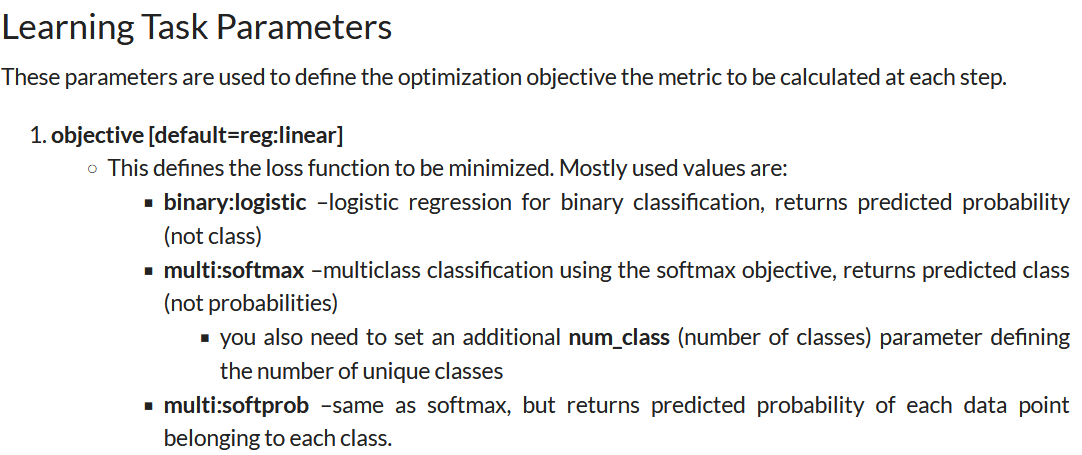

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [ ]:
#model = XGBClassifier(max_depth=10, objective='multi:softprob', n_estimators=700, eta=0.01, min_child_weight=6)
#'subsample': 0.5, 'num_class': 10, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.6
#'subsample': 0.6, 'num_class': 8, 'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6
model = XGBClassifier(subsample=0.6, num_class= 8,n_estimators= 150, max_depth=15, eta= 0.05, colsample_bytree= 0.6, colsample_bylevel= 0.6)
model.fit(X_train, y_train,eval_metric=["mlogloss","merror"], eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.92849	validation_0-merror:0.11998	validation_1-mlogloss:1.92966	validation_1-merror:0.12604
[1]	validation_0-mlogloss:1.79965	validation_0-merror:0.11207	validation_1-mlogloss:1.80197	validation_1-merror:0.11674
[2]	validation_0-mlogloss:1.69145	validation_0-merror:0.11505	validation_1-mlogloss:1.69494	validation_1-merror:0.11910
[3]	validation_0-mlogloss:1.59617	validation_0-merror:0.11186	validation_1-mlogloss:1.60085	validation_1-merror:0.11813
[4]	validation_0-mlogloss:1.51303	validation_0-merror:0.11432	validation_1-mlogloss:1.51859	validation_1-merror:0.11979
[5]	validation_0-mlogloss:1.43659	validation_0-merror:0.11172	validation_1-mlogloss:1.44301	validation_1-merror:0.11882
[6]	validation_0-mlogloss:1.36766	validation_0-merror:0.11124	validation_1-mlogloss:1.37483	validation_1-merror:0.11896
[7]	validation_0-mlogloss:1.30485	validation_0-merror:0.11040	validation_1-mlogloss:1.31298	validation_1-merror:0.11854
[8]	validation_0-mlogloss:1.24764	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_class=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# evaluate predictions
model.score(X_train,y_train)

0.9096241279977788

In [ ]:
model.save_model("model_sklearn.json")

In [ ]:
from sklearn.metrics import accuracy_score
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.13%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, labels=[0,1,2,3,4,5,6,7]))

              precision    recall  f1-score   support

           0       0.67      0.32      0.43       259
           1       0.85      0.39      0.54       196
           2       0.66      0.56      0.60       264
           3       0.74      0.11      0.20       285
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        14
           7       0.90      0.99      0.94      6161

    accuracy                           0.89      7204
   macro avg       0.48      0.30      0.34      7204
weighted avg       0.87      0.89      0.87      7204



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# retrieve performance metrics
results = model.evals_result()


In [ ]:
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

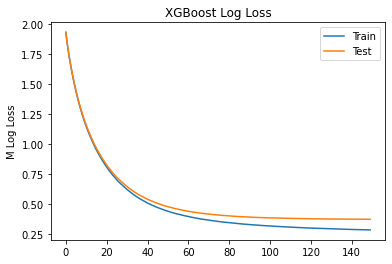

In [ ]:
from matplotlib import pyplot
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('M Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

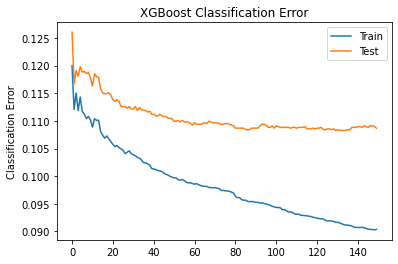

In [ ]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
model.feature_importances_

array([0.03413871, 0.02090961, 0.27797744, 0.0503704 , 0.0506334 ,
       0.03646015, 0.01836525, 0.0185509 , 0.01928058, 0.04501519,
       0.03962931, 0.03211474, 0.07786083, 0.05486484, 0.09906492,
       0.10616141, 0.01860231], dtype=float32)

In [ ]:
model2 = XGBClassifier()
model2.load_model("model_sklearn.json")

In [ ]:
# make predictions for test data
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
X_test.head()

,SERVICIO,PAQUETES,CONTADOR_VISITAS,DEPARTAMENTO,VIA,INCIDENCIA_MANIFIESTO,TIENE_AV,TIENE_JR,TIENE_CALLE,TEMPERATURA,HUMEDAD,CLIMA,INDICE_DELITOS,CANT_FENO_NAT,CANT_PEA,CANT_ACC_TRANSITO,NO_TIENE_REF
1454,6,1,1,11,0,3,1,0,0,16.77,64.0,0,86.473367,483.0,925.2,4367.0,0
18139,1,1,1,11,0,2,0,0,0,17.22,60.0,0,86.473367,483.0,925.2,4367.0,1
20782,2,1,1,2,0,2,1,0,0,17.93,69.0,1,96.754288,1122.0,458.5,1199.0,0
2567,1,1,1,1,0,1,1,0,0,14.48,54.0,1,81.102343,941.0,497.1,1092.0,0
29377,11,1,1,3,0,0,1,0,0,23.48,70.0,1,105.956304,1046.0,4804.5,35848.0,0


In [ ]:
claves = list(dictionarySugerencias.keys())
valores = list(dictionarySugerencias.values())

sugerenciaPred = list()

for i in range(len(predictions)):
  sugerenciaPred.append(list(dictionarySugerencias.keys())[list(dictionarySugerencias.values()).index(predictions[i])])


In [ ]:
y_pred

array([2, 7, 2, ..., 7, 7, 7])

In [ ]:
importances = pd.DataFrame({"columns":X_train.columns, "importances":model.feature_importances_}).sort_values("importances", ascending=False)

In [ ]:
importances.style.bar()

,columns,importances
2,CONTADOR_VISITAS,0.277977
15,CANT_ACC_TRANSITO,0.106161
14,CANT_PEA,0.099065
12,INDICE_DELITOS,0.077861
13,CANT_FENO_NAT,0.054865
4,VIA,0.050633
3,DEPARTAMENTO,0.050370
9,TEMPERATURA,0.045015
10,HUMEDAD,0.039629
5,INCIDENCIA_MANIFIESTO,0.036460


In [ ]:
df = pd.DataFrame()

In [ ]:
df.to_csv( 'dataframe_predict.csv', # Indicar el nombre del archivo
                            index = True,              # Indicar si incluir o no la columna indice. En este caso, como es el DNI, ponemos que sí
                            sep = ';'                  # Indicamos el caracter a usarse como separador
                          )

# Matriz de confusión

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

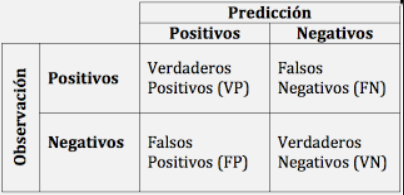

In [ ]:
multilabel_confusion_matrix(y_test, predictions)

array([[[6904,   41],
        [ 176,   83]],

       [[6994,   14],
        [ 119,   77]],

       [[6865,   75],
        [ 117,  147]],

       [[6908,   11],
        [ 253,   32]],

       [[7183,    0],
        [  21,    0]],

       [[7200,    0],
        [   4,    0]],

       [[7190,    0],
        [  14,    0]],

       [[ 401,  642],
        [  79, 6082]]])

# Métrica

In [ ]:
metricF1_score = f1_score(y_test, predictions, average=None)

In [ ]:
metricF1_score

array([0.43342037, 0.53658537, 0.60493827, 0.19512195, 0.        ,
       0.        , 0.        , 0.94404346])

In [ ]:
f1_score(y_test, predictions, average='macro')

0.3392636769503211

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def random_search_tuning():
  
    dataset = dataSetCom.copy()
    X = dataset.drop(columns=['SUGERENCIAS']).copy()
    y = dataset['SUGERENCIAS']

    x_train, x_val, y_train, y_val = train_test_split(X, y, # Vectores X e y
                                                    test_size = 0.2, # Fracción para prueba (en este caso, 20%)
                                                    random_state = semilla_random_state) # Semilla aleatoria, solo con fines de reproducibilidad. Hace que siempre que se ejecute el código,                                                                                       # el resultado sea el mismo. Normalmente no se usaria.

    # define the train set and test set
    print("Shapes - X_train: ", x_train.shape,
          ", X_val: ", x_val.shape, ", y_train: ",
          y_train.shape, ", y_val: ", y_val.shape)

    params = {'max_depth': [3, 6, 10, 15,20],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.05],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 150, 250, 500, 750,1000],
              'num_class': [8]
              }

    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(x_train, y_train)

    best_combination = clf.best_params_

    return best_combination


In [ ]:
best_params = random_search_tuning()

Shapes - X_train:  (28813, 17) , X_val:  (7204, 17) , y_train:  (28813,) , y_val:  (7204,)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print("Best hyperparameter combination: ", best_params)

Best hyperparameter combination:  {'subsample': 0.7, 'num_class': 8, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7999999999999999}
